Points inside shapefile: 4651 out of 15609
FWI data NaNs for day 0: 10958 of 15609


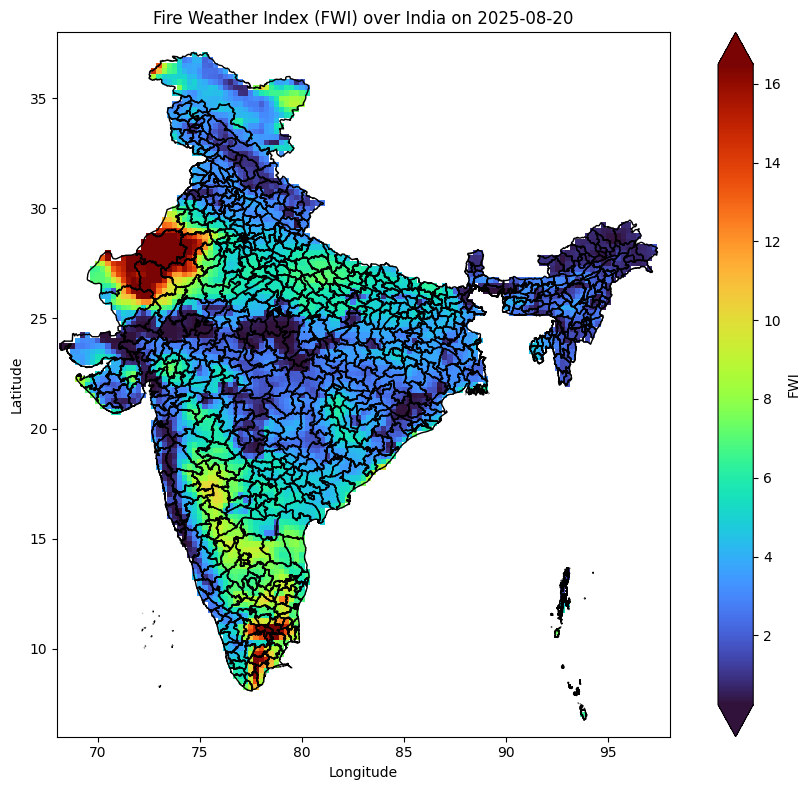

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import sys
import os

# Add project path for wildfire_analysis import
sys.path.append(os.path.abspath('..'))
import wildfire_analysis.cffdrs as cffdrs
from wildfire_analysis.cffdrs import cffdrs_calc

# ----------------------------
# Step 1: Load NetCDF data
# ----------------------------
ds1 = xr.open_dataset('w_n.nc')
ds2 = xr.open_dataset('tp_n.nc')

# Extract and convert units
t2m_c = ds1['t2m'] - 273.15  # K to C
d2m_c = ds1['d2m'] - 273.15
wind_kmh = np.sqrt(ds1['u10']**2 + ds1['v10']**2) * 3.6  # m/s to km/h
precip_mm = ds2['tp'] * 1000  # m to mm

# ----------------------------
# Step 2: Calculate relative humidity
# ----------------------------
def calc_rh(t, d):
    Es = 6.11 * 10.0 ** (7.5 * t / (237.7 + t))
    E = 6.11 * 10.0 ** (7.5 * d / (237.7 + d))
    return (E / Es) * 100.0

rh = calc_rh(t2m_c, d2m_c)

# Prepare month array from datetime
months = ds1['valid_time'].dt.month.values

# ----------------------------
# Step 3: Compute CFFDRS indices
# ----------------------------
result = cffdrs_calc(
    tas=t2m_c.values,        # °C
    pr=precip_mm.values,     # mm/day
    sfcWind=wind_kmh.values, # km/h
    hurs=rh.values,          # %
    mon=months               # months array
)

# ----------------------------
# Step 4: Load Indian shapefile and set CRS
# ----------------------------
shapefile_path = 'DISTRICT_BOUNDARY.shp'  # Your shapefile name here
gdf = gpd.read_file(shapefile_path)

# Reproject shapefile to WGS84 (lat/lon) if not already
if gdf.crs is None or gdf.crs.to_string() != 'EPSG:4326':
    gdf = gdf.to_crs(epsg=4326)

# Extract lat/lon from dataset
lats = ds1['latitude'].values
lons = ds1['longitude'].values
lat_grid, lon_grid = np.meshgrid(lats, lons, indexing='ij')

# Step 5: Create Point objects and test inside polygon mask
points = [Point(lon, lat) for lat, lon in zip(lat_grid.flatten(), lon_grid.flatten())]

india_shape = gdf.unary_union

mask_2d = np.array([india_shape.contains(point) for point in points]).reshape(len(lats), len(lons))

# Diagnostic print for mask coverage
print(f'Points inside shapefile: {np.sum(mask_2d)} out of {mask_2d.size}')

# Broadcast mask for time dimension
mask_3d = np.broadcast_to(mask_2d, (result['fwi'].shape[0], mask_2d.shape[0], mask_2d.shape[1]))

# ----------------------------
# Step 6: Apply mask to results, masking points outside shapefile
# ----------------------------
masked_result = {}
for key in result:
    masked_result[key] = np.where(mask_3d, result[key], np.nan)

# ----------------------------
# Step 7: Build DataFrame and save CSV
# ----------------------------
dates = ds1['valid_time'].values
nt = masked_result['fwi'].shape[0]
nlat = masked_result['fwi'].shape[1]
nlon = masked_result['fwi'].shape[2]

times = np.repeat(dates, nlat * nlon)
lat_grid_flat = np.tile(np.repeat(lats, nlon), nt)
lon_grid_flat = np.tile(np.tile(lons, nlat), nt)

def flatten(arr):
    return arr.reshape(-1)

df = pd.DataFrame({
    'time': times,
    'lat': lat_grid_flat,
    'lon': lon_grid_flat,
    'FFMC': flatten(masked_result['ffmc']),
    'DMC': flatten(masked_result['dmc']),
    'DC': flatten(masked_result['dc']),
    'ISI': flatten(masked_result['isi']),
    'BUI': flatten(masked_result['bui']),
    'FWI': flatten(masked_result['fwi']),
    'DSR': flatten(masked_result['dsr']),
})

# Drop points outside shape (NaNs)
df = df.dropna(subset=['FWI'])

df.to_csv('cffdrs_masked_india_timeseries.csv', index=False)

# ----------------------------
# Step 8: Save masked results to NetCDF
# ----------------------------
ds_out_masked = xr.Dataset(
    {
        'FFMC': (('time', 'lat', 'lon'), masked_result['ffmc']),
        'DMC': (('time', 'lat', 'lon'), masked_result['dmc']),
        'DC': (('time', 'lat', 'lon'), masked_result['dc']),
        'ISI': (('time', 'lat', 'lon'), masked_result['isi']),
        'BUI': (('time', 'lat', 'lon'), masked_result['bui']),
        'FWI': (('time', 'lat', 'lon'), masked_result['fwi']),
        'DSR': (('time', 'lat', 'lon'), masked_result['dsr']),
    },
    coords={
        'time': dates,
        'lat': lats,
        'lon': lons,
    }
)

ds_out_masked.to_netcdf('cffdrs_masked_india.nc')

# ----------------------------
# Step 9: Plotting
# ----------------------------
fwi_oneday = ds_out_masked['FWI'].isel(time=0)
print(f'FWI data NaNs for day 0: {np.isnan(fwi_oneday.values).sum()} of {fwi_oneday.size}')

plt.figure(figsize=(10, 8))
ax = plt.gca()
fwi_oneday.plot(cmap="turbo", robust=True, ax=ax)

gdf.boundary.plot(ax=ax, color='black', linewidth=1)

ax.set_xlim(lons.min(), lons.max())
ax.set_ylim(lats.min(), lats.max())

plt.title(f"Fire Weather Index (FWI) over India on {str(dates[0])[:10]}")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()
